The following analysis was executed using commit `b6e4fe952` of the [exosyspop](github.com/timothydmorton/exosyspop) module.

In [40]:
# Set up plot stuff the DFM way:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%run ../peerless/plot_setup.py

In [41]:
!../scripts/peerless-targets

Saving 39036 targets to /Users/tdm/peerless/catalogs/targets.csv


In [76]:
from peerless.catalogs import TargetCatalog, EBCatalog, KICatalog
targets = TargetCatalog().df
targets.index = targets.kepid

In [43]:
targets[['kepid','mass','feh']].count()

kepid    39036
mass     39036
feh      39036
dtype: int64

In [44]:
# funny, there seem to be some missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

In [45]:
# Calculate galactic latitude of target stars
from astropy.coordinates import SkyCoord
c = SkyCoord(targets.ra, targets.dec, unit='deg')
targets['b'] = c.galactic.b.deg

In [46]:
from exosyspop.populations import KeplerPowerLawBinaryPopulation
from exosyspop.populations import TRILEGAL_BGPowerLawBinaryPopulation

ebpop = KeplerPowerLawBinaryPopulation(targets, ecc_empirical=True)
bgstars = pd.read_hdf('bgstars.h5', 'df')
bgpop = TRILEGAL_BGPowerLawBinaryPopulation(targets, bgstars, ecc_empirical=True, use_ic=True)

136.401367662
EB: dmag regressor trained, R2=0.999418105084
EB: qR regressor trained, R2=0.999477508708
154


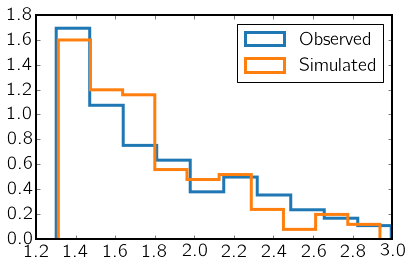

In [51]:
from __future__ import division

min_period = 20
max_period = 25*365.25
fB = 0.15
beta = -1.1
ebpop.set_params(beta=beta, period_min=min_period, period_max=max_period, fB=fB)

q = 'period > {} and period < 1000 and '.format(min_period) +\
    '((n_pri > 0 and n_sec > 0) or ' +\
     '(n_pri > 2 or n_sec > 2)) and (T14_pri < 2.5 or T14_sec < 2.5)'

kep_ebs = EBCatalog().df.query('{} < period < 1000'.format(min_period))
n_exp = len(kep_ebs) * (len(targets)/len(KICatalog().df))
print(n_exp)
plt.hist(np.log10(kep_ebs.period), 
         histtype='step', lw=3, normed=True, label='Observed');
new_obs = ebpop.observe(new_orbits=True).query(q)
plt.hist(np.log10(new_obs.period), label='Simulated',
        histtype='step', lw=3, normed=True);
plt.legend()
print(len(new_obs))

In [105]:
len(kep_ebs)

698

In [52]:
ebpop.params

{'beta': -1.1,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.15,
 'gamma': 0.3,
 'period_max': 9131.25,
 'period_min': 20,
 'qmin': 0.1}

In [53]:
# Set params to match above
pars = dict(period_min=min_period, period_max=max_period, beta=beta, fB=fB)
ebpop.set_params(**pars)
bgpop.set_params(**pars)
ebpop._generate_binaries()
bgpop._generate_binaries()

Let's do a bunch of these observation simulations and see what it looks like:

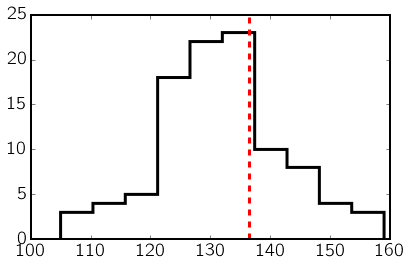

In [54]:
n_obs = [len(ebpop.observe(new_orbits=True).query(q)) for i in range(100)]

plt.hist(n_obs, histtype='step', lw=3, bins=10, color='k');
plt.axvline(n_exp, color='r', ls='--', lw=3);

OK, now that we can roughly match the Kepler EB catalog from 20 to 1000d with these EB population parameters, we want to know what's the typical number of single/double eclipse signals.

In [55]:
ebpop._train_trap(N=1000);
bgpop._train_trap(N=1000);

EB: Depth trained: R2=0.99839999824
EB: Duration trained: R2=0.995463985808
EB: Slope trained: R2=0.980524248976
BGEB: Depth trained: R2=0.994453508054
BGEB: Duration trained: R2=0.993045791029
BGEB: Slope trained: R2=0.978815305719


In [56]:
n_sim = 100
dfm_q = 'n_pri < 3 and n_sec < 3 and ' +\
        '(((n_pri==0 or snr_pri < 15) and snr_sec > 15) or ' +\
        '((n_sec==0 or snr_sec < 15)  and snr_pri > 15))'
dfm_q += ' and ((T14_pri < 2.5 and n_pri > 0) or (T14_sec < 2.5 and n_sec > 0))'
nobs_eb = [len(ebpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(n_sim)]
nobs_bg = [len(bgpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(n_sim)]

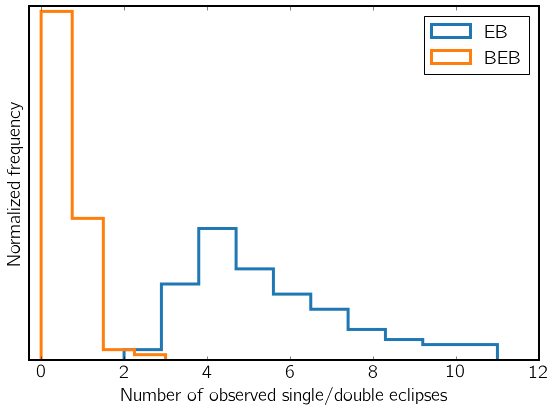

In [64]:
plt.figure(figsize=(8,6))
plt.hist(nobs_eb, histtype='step', lw=3, label='EB', bins=10)#, bins=np.arange(16));
plt.hist(nobs_bg, histtype='step', lw=3, label='BEB', bins=4)#, bins=np.arange(16));
plt.legend();
plt.xlim(xmin=-0.3)
plt.yticks([])
plt.ylabel('Normalized frequency')
plt.xlabel('Number of observed single/double eclipses');
plt.savefig('N_EBs.pdf', bbox_inches='tight')

OK, now let's determine the typical shapes.  Let's do this with a big sample of simulated observations.

In [65]:
np.mean(nobs_eb), np.mean(nobs_bg)

(5.3799999999999999, 0.34999999999999998)

In [66]:
# Here, defining population to match what was fit for in the paper
from exosyspop.populations import PlanetPopulation, REARTH

import astropy.constants as const
RJUP = const.R_jup.cgs
RSUN = const.R_sun.cgs

class LongPeriodPlanetPopulation(PlanetPopulation):
    """
    Poisson Population in two bins: 0.1-0.4 RJup and 0.4-1.0 RJup
    
    From 2 to 25 years, with beta eccentricity distribution
    """
    min_period = 2*365.25
    max_period = 25*365.25
    
    vol1 = (np.log(0.4) - np.log(0.1))*(np.log(max_period) - np.log(min_period))
    vol2 = (np.log(1) - np.log(0.4))*(np.log(max_period) - np.log(min_period))
    
    param_names = ('Gam1', 'Gam2', 'beta_a', 'beta_b')
    default_params = {'Gam1':0.4, 'Gam2':0.18,
                      'beta_a':1.12, 'beta_b':3.09}
    
    def _sample_period(self, N):
        lo = np.log(self.min_period)
        hi = np.log(self.max_period)
        logp = np.random.random(N)*(hi - lo) + lo
        return np.exp(logp)
    
    def _sample_Np(self, N):
        Gam1, Gam2 = self._get_params(['Gam1', 'Gam2'])
        
        N_pl = Gam1*self.vol1 + Gam2*self.vol2 # Sum of both bins is total rate
        return np.random.poisson(N_pl, size=N)
    
    def _sample_Rp(self, N):
        Gam1, Gam2 = self._get_params(['Gam1', 'Gam2'])
        Nexp1 = Gam1*self.vol1
        Nexp2 = Gam2*self.vol2
        
        # Assign radii uniformly in each bin, with appropriate ratio given to each bin
        f1 = Nexp1 / (Nexp1 + Nexp2)
        u = np.random.random(N)
        in_1 = u < f1
        in_2 = u >= f1
        N1 = in_1.sum()
        N2 = in_2.sum()
        
        Rp = np.ones(N)
        lo1, hi1 = np.log(0.1), np.log(0.4)
        lo2, hi2 = np.log(0.4), np.log(1)
        Rp[in_1] = np.exp(np.random.random(N1)*(hi1 - lo1) + lo1)
        Rp[in_2] = np.exp(np.random.random(N2)*(hi2 - lo2) + lo2)
        return Rp * RJUP/RSUN

In [78]:
plpop = LongPeriodPlanetPopulation(targets)

plpop._train_trap(N=1000);
_ = plpop.observe()

Planet: Depth trained: R2=0.997901341428
Planet: Duration trained: R2=0.990421987754
Planet: Slope trained: R2=0.978679217352


OK, now let's load up the candidates.

In [80]:
candidates = pd.read_csv('../results/fits.csv', index_col=0)
print(candidates.columns)
print(len(candidates))
candidates['s2n'] = candidates.depth*1000/plpop.get_noise(candidates.index, candidates.duration) * np.sqrt(candidates.n_transits)
candidates['rstar'] = targets.ix[candidates.index, 'radius']
candidates.depth *= 1e-3
candidates.duration /= 24.
candidates[['depth','duration','period','radius','rstar','impact','n_transits','s2n']]

Index([u'depth', u'depth_uncert_minus', u'depth_uncert_plus', u'duration',
       u'duration_uncert_minus', u'duration_uncert_plus', u'eccen',
       u'eccen_uncert_minus', u'eccen_uncert_plus', u'impact',
       u'impact_uncert_minus', u'impact_uncert_plus', u'mass',
       u'mass_uncert_minus', u'mass_uncert_plus', u'n_transits', u'period',
       u'period_uncert_minus', u'period_uncert_plus', u'radius',
       u'radius_uncert_minus', u'radius_uncert_plus', u'rvaccel',
       u'rvaccel_uncert_minus', u'rvaccel_uncert_plus', u'semiamp',
       u'semiamp_uncert_minus', u'semiamp_uncert_plus', u'semimajor',
       u'semimajor_uncert_minus', u'semimajor_uncert_plus', u't0',
       u't0_uncert_minus', u't0_uncert_plus', u'teq', u'teq_uncert_minus',
       u'teq_uncert_plus'],
      dtype='object')
16


,depth,duration,period,radius,rstar,impact,n_transits,s2n
kicid,,,,,,,,
11709124,0.008777,0.739623,4.264997,0.828526,0.971,0.512708,1,103.742952
9306307,0.060297,0.354141,4.252540,1.220102,0.915,0.639900,1,424.324242
10321319,0.000374,0.701656,5.522778,0.163172,0.941,0.473659,1,15.994137
3239945,0.018865,0.675076,2.932872,0.875794,0.710,0.206589,2,402.787682
8410697,0.005724,0.823828,2.868810,0.698399,1.003,0.153588,2,148.615011
10287723,0.001458,0.395524,4.878759,0.265570,0.726,0.680744,1,26.992640
8426957,0.005522,1.640239,54.248522,1.039960,1.080,0.889371,1,127.168467
8738735,0.001237,1.143376,9.860707,0.354537,1.044,0.283580,1,19.297674
6551440,0.001072,0.452081,4.020863,0.281950,1.096,0.604324,1,20.423233


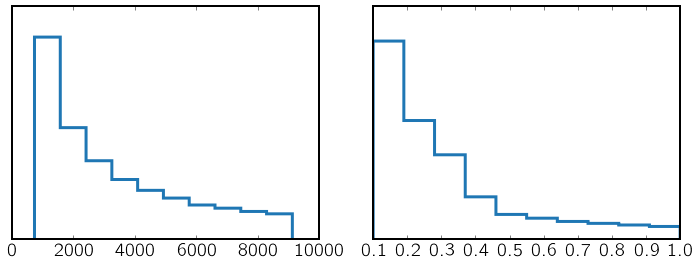

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(plpop.period, histtype='step', lw=3);
ax1.set_yticks([])
ax2.hist(plpop.radius_B*RSUN/RJUP, histtype='step', lw=3);
ax2.set_yticks([]);

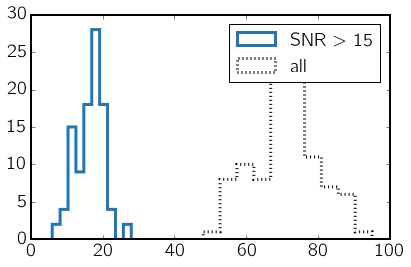

In [83]:
dfm_q_pl = 'n_pri < 3 and snr_pri > 15 and T14_pri < 2.5'
dfm_q_pl_nosnr = 'n_pri < 3 and T14_pri < 2.5 and snr_pri > 0'

nobs_pl = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl)) for i in range(100)]
nobs_pl2 = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl_nosnr)) for i in range(100)]

plt.hist(nobs_pl, histtype='step', lw=3, label='SNR $>$ 15');
plt.hist(nobs_pl2, histtype='step', lw=3, color='k', ls=':', label='all')
plt.legend(loc='upper right');

In [84]:
np.mean(nobs_pl)

16.460000000000001

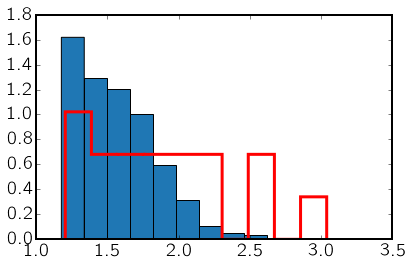

In [85]:
plt.hist(np.log10(pl_obs.snr_pri), normed=True);
plt.hist(np.log10(candidates.s2n.values), histtype='step', color='r', lw=3, normed=True);

In [81]:
def plot_kde(kde, ax=None, dur_range=(0,2.), depth_range=(-3.5,-0.5), 
            cands=candidates, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    dur_grid = np.arange(dur_range[0], dur_range[1], 0.02)
    depth_grid = np.arange(depth_range[0], depth_range[1], 0.02)
    xx, yy = np.meshgrid(dur_grid, depth_grid)
    f = kde(np.vstack([xx.ravel(),yy.ravel()])).reshape(xx.shape)
    ax.imshow(f, origin='lower', extent=[dur_range[0], dur_range[1],
                                         depth_range[0], depth_range[1]], 
               aspect='auto', cmap='binary', **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log(depth)')
    
    if cands is not None:
        ax.plot(cands.duration, np.log10(cands.depth), 'rx', ms=10)


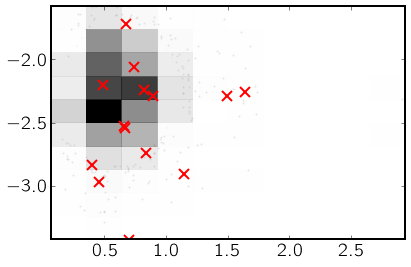

In [90]:
from corner import hist2d
N = 1000
pl_obs = plpop.get_N_observed(query=dfm_q_pl, N=N)

hist2d(pl_obs.observed.dur_pri.values, pl_obs.observed.logd_pri.values,
          plot_contours=False, bins=10);

plt.plot(candidates.duration, np.log10(candidates.depth), 'rx', ms=10);

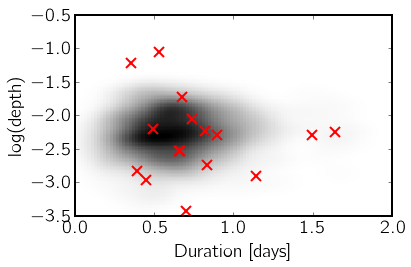

In [91]:
pl_kde = gaussian_kde(np.array([pl_obs.observed.dur_pri, pl_obs.observed.logd_pri]))
plot_kde(pl_kde)

OK, now simulate large populations of EBs, BEBs

In [86]:
eb_obs = ebpop.get_N_observed(query=dfm_q, N=2000, new_orbits=True)
bg_obs = bgpop.get_N_observed(query=dfm_q, N=200, use_ic=True, new_orbits=True) #takes longer; use fewer

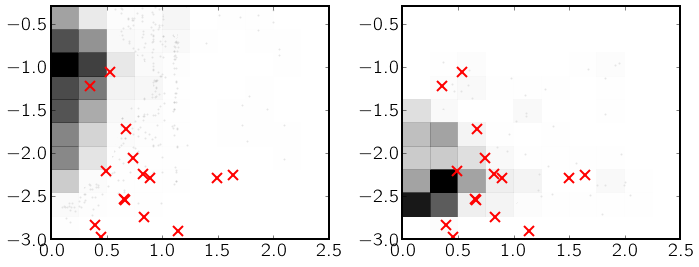

In [87]:
from corner import hist2d

fix, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

hist2d(eb_obs.observed.dur_pri.values, eb_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax1, range=[(0,2.5), (-3, -0.3)], bins=10);
hist2d(bg_obs.observed.dur_pri.values, bg_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax2, range=[(0,2.5), (-3, -0.3)], bins=10);

for ax in (ax1, ax2):
    ax.plot(candidates.duration, np.log10(candidates.depth), 'rx', ms=10)


In [88]:
from scipy.stats import gaussian_kde

eb_kde = gaussian_kde(np.array([eb_obs.observed.dur_pri, eb_obs.observed.logd_pri]))
bg_kde = gaussian_kde(np.array([bg_obs.observed.dur_pri, bg_obs.observed.logd_pri]))

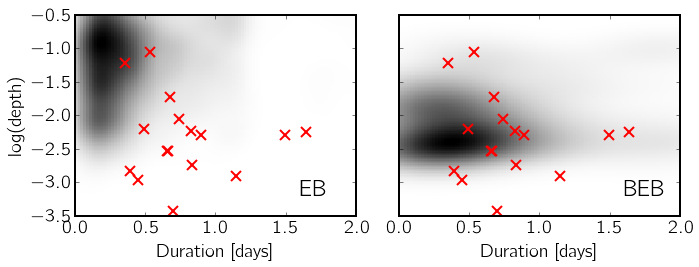

In [89]:
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB']):
    ax.annotate(title, xy=(0.8,0.1), xycoords='axes fraction', fontsize=22)

In [96]:
n_sim = 100
nobs_pl = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl)) for i in range(n_sim)]

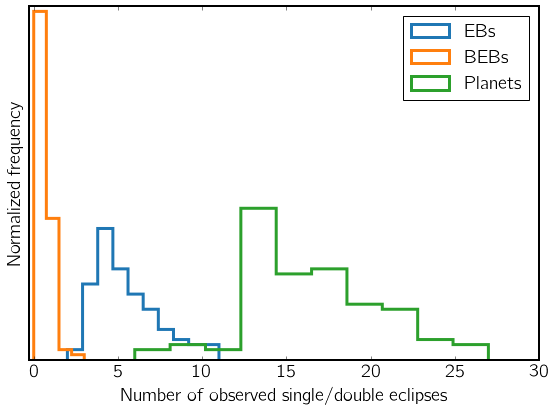

In [99]:
plt.figure(figsize=(8,6))
plt.hist(nobs_eb, histtype='step', lw=3, label='EBs', bins=10)#, bins=np.arange(16));
plt.hist(nobs_bg, histtype='step', lw=3, label='BEBs', bins=4)#, bins=np.arange(16));
plt.hist(nobs_pl, histtype='step', lw=3, label='Planets')
plt.legend();
plt.xlim(xmin=-0.3)
plt.yticks([])
plt.ylabel('Normalized frequency')
plt.xlabel('Number of observed single/double eclipses');
plt.savefig('N_predicted.pdf', bbox_inches='tight')

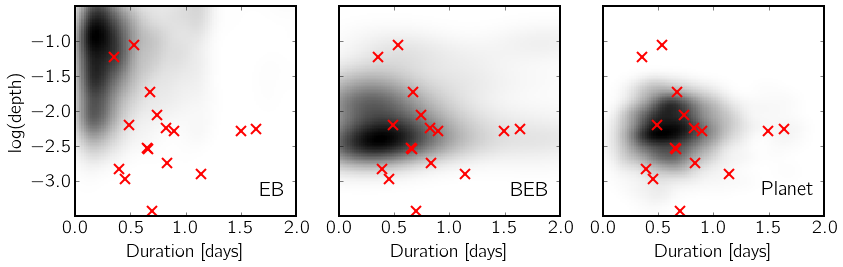

In [100]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
plot_kde(pl_kde, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB','Planet']):
    ax.set_yticks(np.arange(-3,-0.5,0.5))
    ax.annotate(title, xy=(0.95,0.1), xycoords='axes fraction', fontsize=20, ha='right')
    
plt.savefig('shape_kdes.pdf', bbox_inches='tight')

OK, now we can guess the nature of each individual signal, given our predicted rates and the depth-duration shape information:

In [102]:
pts = [candidates.duration, np.log10(candidates.depth)]
L_eb = eb_kde(pts)
L_bg = bg_kde(pts)
L_pl = pl_kde(pts)

pi_eb = 5.4
pi_bg = 0.15
pi_pl = 12

norm = L_eb*pi_eb + L_bg*pi_bg + L_pl*pi_pl

candidates['pr_eb'] = L_eb*pi_eb / norm
candidates['pr_bg'] = L_bg*pi_bg / norm
candidates['pr_pl'] = L_pl*pi_pl / norm

In [103]:
candidates[['pr_eb', 'pr_bg', 'pr_pl']].sum()

pr_eb     2.224691
pr_bg     0.113819
pr_pl    13.661490
dtype: float64

In [104]:
candidates[['radius','depth', 'duration', 'pr_eb', 'pr_bg', 'pr_pl']]

,radius,depth,duration,pr_eb,pr_bg,pr_pl
kicid,,,,,,
11709124,0.828526,0.008777,0.739623,0.026333,0.004298,9.693686e-01
9306307,1.220102,0.060297,0.354141,0.996527,0.003341,1.324016e-04
10321319,0.163172,0.000374,0.701656,0.000002,0.000081,9.999172e-01
3239945,0.875794,0.018865,0.675076,0.101358,0.005861,8.927806e-01
8410697,0.698399,0.005724,0.823828,0.010706,0.005085,9.842093e-01
10287723,0.265570,0.001458,0.395524,0.021180,0.007679,9.711412e-01
8426957,1.039960,0.005522,1.640239,0.001281,0.016811,9.819083e-01
8738735,0.354537,0.001237,1.143376,0.001041,0.003580,9.953793e-01
6551440,0.281950,0.001072,0.452081,0.004252,0.003258,9.924893e-01
